In [1]:
import numpy as np
import numpy.testing as npt
from scipy.linalg import expm
import matplotlib.pyplot as plt
import scipy.spatial, scipy.linalg
from scipy.spatial.distance import pdist
import scipy.sparse.linalg
from scipy.linalg import eigh
import zipfile,io
import pandas as pd
import zipfile
import re
%matplotlib inline

def computeCorrelation(x,s, label="X"):
    x_size = x.shape[0]
    data = np.vstack((x,s))
    corrs = np.corrcoef(data)
    corrs_trimmed = corrs[:x_size, x_size:,]

    return corrs_trimmed

def sigmoid(y):
    return 1/(1+np.exp(-y))

## 6.1 Natural Gradient

(a) Extend your code from the previous problem sheet to get an ICA-learning scheme based on the natural gradient with a learning rate " that decays slowly to 0 (e.g. "t+1 = λ"t with λ ≈ 1; λ < 1). Note that depending on λ you have to iterate over the (shuffled) data more than once for proper convergence.

In [2]:
def natGrad(X, W, eps=0.001,l=0.99):
    n = len(X)
    p=len(X[0])
    dw = np.array(W)
    ww = np.array(W)
    rmidx = np.random.choice(p,p,replace=False)
    XX=X[:,rmidx]
    # natural gradient  
    for i in range(p):
        y = np.dot(ww,XX[:,i].reshape(n,1))
        sig = 1 -2*sigmoid(y)
        dw= ww + np.dot(np.dot(sig,XX[:,i].reshape(1,n)),np.dot(ww.T,ww))
        ww=ww+eps*dw
        eps=eps*l
    return ww

In [3]:
def plotExperiment(x, w_init, original_s,  dataset):
    total = x.shape[1]
    x_range = np.array(range(total))
    
    plt.figure(figsize=(10,10))
    
    for i in range(x.shape[0]):
        plt.subplot(5,2,i+1)
        plt.plot(x_range, x[i,:].T)
        plt.title('%s : Mixed signal %d' % (dataset, i+1) )
        plt.xticks([])
        plt.yticks([])
        

    w_nat= natGrad(XX, W, 0.002)
    s_est = np.dot(w_nat,x) 
    corr = computeCorrelation(s_est, original_s)
    learning_algo = 'nat_grad'
    for i in range(x.shape[0]):
        plt.subplot(5,2,2+ i+1)
        plt.plot(x_range, s_est[i,:].T)
        plt.title('%s : %s %d (corr %.4f)' % (learning_algo, 'De-mixed signal', i+1, corr[i,i]) )
        plt.xticks([])
        plt.yticks([])
        
    for i in range(x.shape[0]):
        plt.subplot(5,2,4+ i+1)
        plt.plot(x_range, original_s[i,:].T)
        plt.title('%s %d' % ('Original signal', i+1) )
        plt.xticks([])
        plt.yticks([])




b) Use the two sound signals from the last problem sheet and add (as third source s3) an additional “noise” source (normally distributed random numbers with a standard deviation similar to the two signals). Mix the signals using a mixing matrix of your choice and apply your ICA-algorithm. Plot the Mixed Sounds and recovered Sources

In [4]:
unzip = zipfile.ZipFile("sounds.zip", 'r')          
fl = unzip.namelist()                     
s1 = unzip.open(fl[0])
s2 = unzip.open(fl[1])
dat1 = pd.read_table(s1,header=None,delim_whitespace=True)
dat2 = pd.read_table(s2,header=None,delim_whitespace=True)
sig1 = np.array(dat1)
sig2 = np.array(dat2)
S= np.append(sig1 ,sig2,1)
Snoise = S+np.std(S,0)*np.random.randn(len(S),2)
A =np.array( [[ 0.63610688,0.46237165], [ 0.95995455, 0.17711994]])
X = np.dot(A,Snoise.T)
X

array([[-0.89979358, -0.02618562,  1.06487082, ..., -0.79827642,
        -0.28352631,  1.19904525],
       [-0.67767803, -0.22122827,  1.45336403, ..., -0.94139465,
        -0.24852484,  1.34457755]])

In [5]:
W = np.array([[ 0.58870338, 0.42567703],[ 0.66824231,0.62259454]])
W

array([[ 0.58870338,  0.42567703],
       [ 0.66824231,  0.62259454]])

In [6]:
ww = natGrad(X, W, eps=0.003,l=0.99)
x = X.T
SS = np.dot(ww,X)
s = SS.T

([], <a list of 0 Text yticklabel objects>)

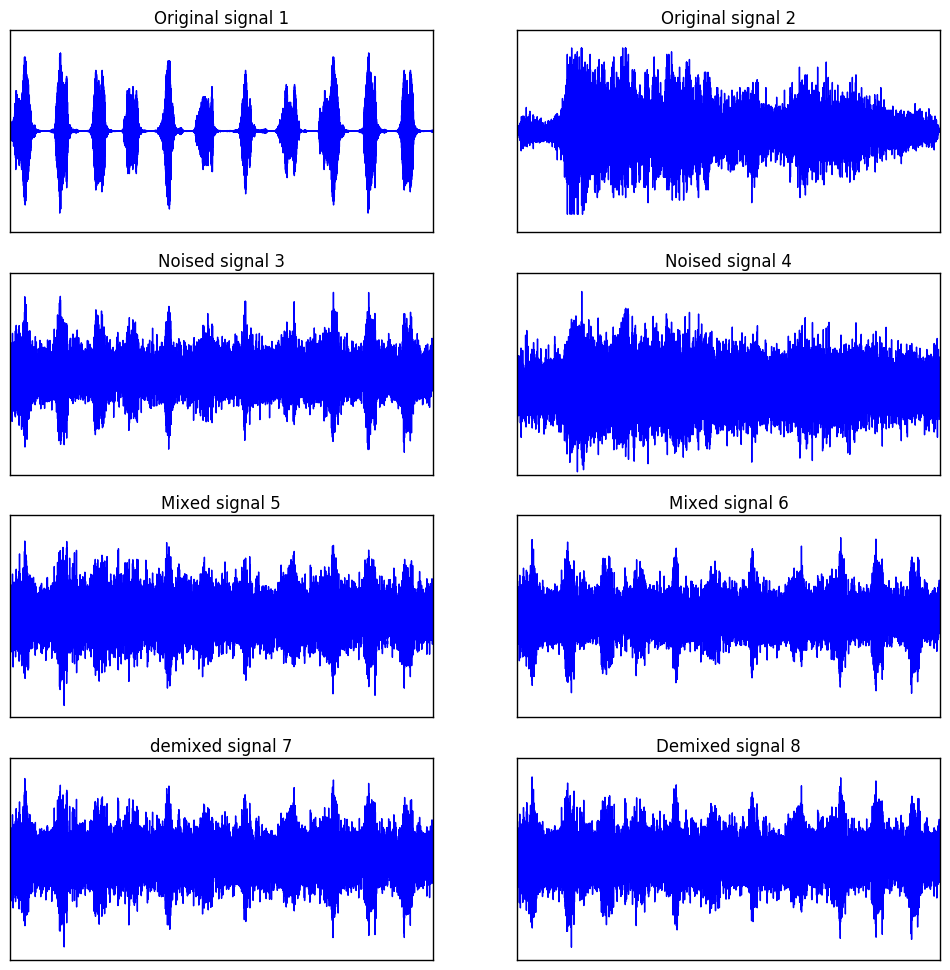

In [7]:
plt.figure(figsize=(12,12))
p = len(S)
lang = np.arange(p)

plt.subplot(4,2,1)
plt.plot(lang, S[:,0])
plt.title('%s %d' % ('Original signal', 1) )
plt.xticks([])
plt.yticks([])

plt.subplot(4,2,2)
plt.plot(lang, S[:,1])
plt.title('%s %d' % ('Original signal', 2) )
plt.xticks([])
plt.yticks([])

plt.subplot(4,2,3)
plt.plot(lang, Snoise[:,0])
plt.title('%s %d' % ('Noised signal', 3) )
plt.xticks([])
plt.yticks([])

plt.subplot(4,2,4)
plt.plot(lang, Snoise[:,1])
plt.title('%s %d' % ('Noised signal', 4) )
plt.xticks([])
plt.yticks([])

plt.subplot(4,2,5)
plt.plot(lang, x[:,0])
plt.title('%s %d' % ('Mixed signal', 5) )
plt.xticks([])
plt.yticks([])

plt.subplot(4,2,6)
plt.plot(lang, x[:,1])
plt.title('%s %d' % ('Mixed signal', 6) )
plt.xticks([])
plt.yticks([])

plt.subplot(4,2,7)
plt.plot(lang, s[:,0])
plt.title('%s %d' % ('demixed signal', 7) )
plt.xticks([])
plt.yticks([])

plt.subplot(4,2,8)
plt.plot(lang, s[:,1])
plt.title('%s %d' % ('Demixed signal', 8) )
plt.xticks([])
plt.yticks([])

(c) Do the same analysis but adding a different “noise”-source (e.g. Laplace distributed) instead of the normal one.

In [8]:
lap=np.random.laplace(size=(S.shape))
S_lap = S+lap
X_lap = np.dot(A,S_lap.T)

In [9]:
w_lap = natGrad(X_lap, W, eps=0.003,l=0.99)

In [10]:
SS_lap = np.dot(w_lap, X_lap)

([], <a list of 0 Text yticklabel objects>)

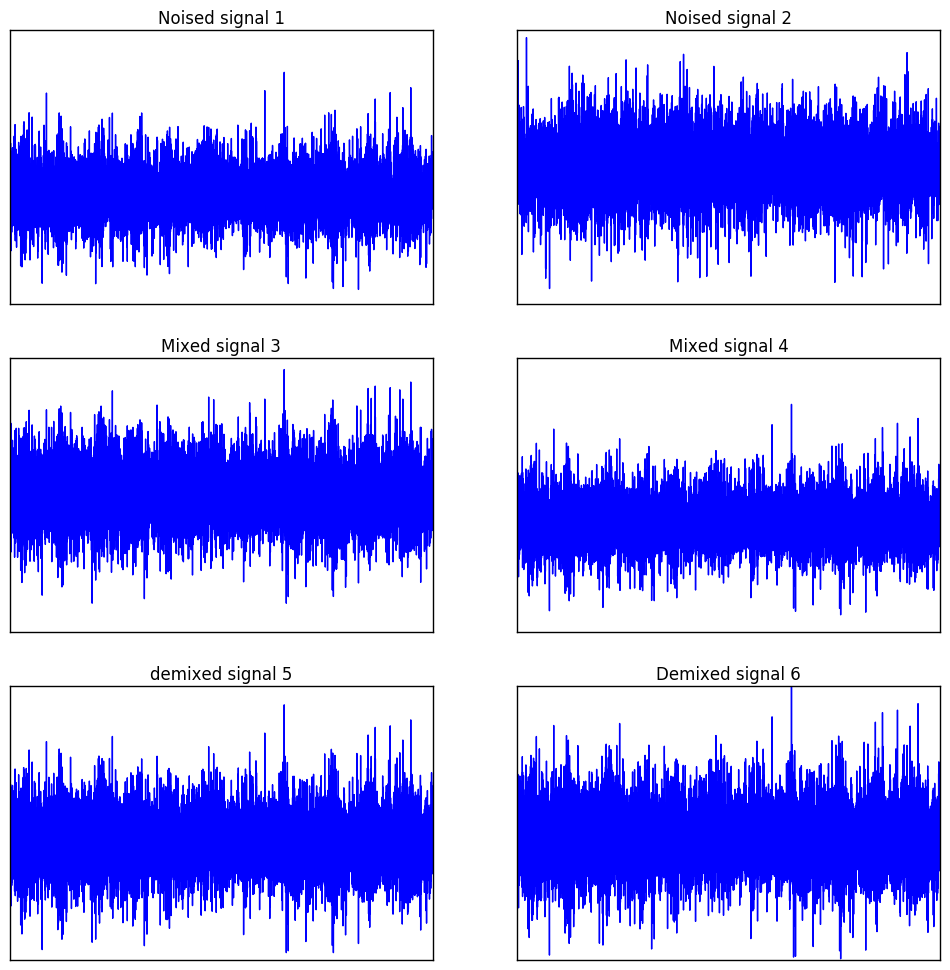

In [11]:
plt.figure(figsize=(12,12))
p = len(S)
lang = np.arange(p)


plt.subplot(3,2,1)
plt.plot(lang, S_lap[:,0])
plt.title('%s %d' % ('Noised signal', 1) )
plt.xticks([])
plt.yticks([])

plt.subplot(3,2,2)
plt.plot(lang, S_lap[:,1])
plt.title('%s %d' % ('Noised signal', 2) )
plt.xticks([])
plt.yticks([])

plt.subplot(3,2,3)
plt.plot(lang, X_lap.T[:,0])
plt.title('%s %d' % ('Mixed signal', 3) )
plt.xticks([])
plt.yticks([])

plt.subplot(3,2,4)
plt.plot(lang, X_lap.T[:,1])
plt.title('%s %d' % ('Mixed signal', 4) )
plt.xticks([])
plt.yticks([])

plt.subplot(3,2,5)
plt.plot(lang, SS_lap.T[:,0])
plt.title('%s %d' % ('demixed signal', 5) )
plt.xticks([])
plt.yticks([])

plt.subplot(3,2,6)
plt.plot(lang, SS_lap.T[:,1])
plt.title('%s %d' % ('Demixed signal', 6) )
plt.xticks([])
plt.yticks([])

## 6.2 Moments of univariate distributions

Calculate the first 4 moments of the different random variables depending on the respective parameters. In addition to providing the derivation (e.g. by using the characteristic function) fill the following table:

In [12]:
gaus = np.random.randn(100)
laplas = np.random.laplace(size=100)
uni = np.random.uniform(-1,1,size=100)


In [13]:
lfm = laplas.mean()
gfm = gaus.mean()
ufm = uni.mean()
print("First moment")
print(lfm)
print(gfm)
print(ufm)
lsm = ((laplas-lfm)**2).mean()
gsm = ((gaus-gfm)**2).mean()
usm = ((uni-ufm)**2).mean()
print("Second moment")
print(lsm)
print(gsm)
print(usm)
ltm = ((laplas-lfm)**3).mean()/np.sqrt(lsm)
gtm = ((gaus-gfm)**3).mean()/np.sqrt(gsm)
utm = ((uni-ufm)**3).mean()/np.sqrt(usm)
print("Third moment")
print(ltm)
print(gtm)
print(utm)
l4m = ((laplas-lfm)**4).mean()/np.sqrt(lsm)
g4m = ((gaus-gfm)**4).mean()/np.sqrt(gsm)
u4m = ((uni-ufm)**4).mean()/np.sqrt(usm)
print("4th moment")
print(l4m)
print(g4m)
print(u4m)

First moment
0.0762244665429
0.105608943134
0.0421149532584
Second moment
2.30680090715
0.771846710896
0.291656158594
Third moment
-0.816411688607
0.275901803793
0.00470676747131
4th moment
16.4091410512
2.17833629764
0.280894518782


<table>
    <tr>
        <td>
            
        </td>
        <td>
           Laplace ($\mu$, b)
        </td>
        <td>
           Gauß ($\mu$, $\sigma$) 
        </td>
        <td>
           Uniform (a, b)
        </td>
    </tr>
    <tr>
        <td>
            mean: first moment 
        </td>
        <td>
           0.0762244665429
        </td>
        <td>
            0.105608943134
        </td>
        <td>
            0.0421149532584
        </td>
    </tr>
    <tr>
        <td>
            variance: second centered mome
        </td>
        <td>
            2.30680090715
        </td>
        <td>
            0.771846710896
        </td>
        <td>
           0.291656158594
        </td>
    </tr>
    
    <tr>
        <td>
            skewness: third standardized moment 
        </td>
        <td>
            -0.816411688607
        </td>
        <td>
            0.275901803793
        </td>
        <td>
            0.00470676747131
        </td>
    </tr>
    
    <tr>
        <td>
            kurtosis: fourth standardized moment
        </td>
        <td>
            16.4091410512
        </td>
        <td>
            2.17833629764
        </td>
        <td>
            0.280894518782
        </td>
    </tr>


</table>

## 6.3 Kurtosis of Toy Data

The file distrib.mat contains three toy datasets (uniform, normal, laplacian), each 10000 samples of 2 sources. Do the following for each dataset (which can be read for example using Python with loadmat from scipy.io):

In [14]:
import numpy as np
import numpy.testing as npt
from scipy.linalg import expm
import matplotlib.pyplot as plt
import scipy.spatial, scipy.linalg
from scipy.spatial.distance import pdist
import scipy.sparse.linalg
from scipy.linalg import eigh
import zipfile,io
import pandas as pd
import zipfile
import re
%matplotlib inline

from scipy.io import loadmat
dismat = loadmat('distrib.mat')
fm = list(dismat)
print(fm)
suni=dismat['uniform']
snom=dismat['normal']
slap=dismat['laplacian']

['uniform', '__header__', 'normal', '__version__', 'laplacian', '__globals__']


(a) Apply the following mixing matrix A to the original data s:

In [15]:
A = np.array([[4,3],[2,1]])
xuni = np.dot(A,suni)
xnom = np.dot(A,snom)
xlap = np.dot(A,slap)

(b) Center the mixed data to zero mean.

In [16]:
xunic = xuni - xuni.mean(1).reshape(2,1)
xnomc = xnom - xnom.mean(1).reshape(2,1)
xlapc = xlap - xlap.mean(1).reshape(2,1)

(c) Decorrelate the data by applying principal component analysis (PCA) and project them onto the principal components (PCs).

In [17]:
class PCA():
    def __init__(self, X):
        # ...
        C = np.cov(X)
        D, U = np.linalg.eigh(C)
        idx = np.argsort(-D)
        self.U = U[:,idx]
        self.D = D[idx]
        
    def project(self, X, m):
        # ...
        U = self.U
        M = U[:,:m] 
        Z = np.dot(M.T,X)
        return Z
    
    def denoise(self, X, m):
        Z = self.project(X,m)
        U = self.U
        Y = np.dot(U[:,:m],Z)
        Y = Y + np.mean(X,axis=1).reshape(len(Y),1)
        return Y
    

In [18]:
upca = PCA(xunic)
npca = PCA(xnomc)
lpca = PCA(xlapc)


In [19]:
unideco = upca.project(xunic,2)
nomdeco = npca.project(xnomc,2)
lapdeco = lpca.project(xlapc,2)

In [20]:
lapdeco.shape

(2, 10000)

(d) Scale the data to unit variance in each PC direction (now the data is whitened or sphered)

In [21]:
vuni = np.dot(np.diag(np.sqrt(1/upca.D)),unideco)
vnom = np.dot(np.diag(np.sqrt(1/npca.D)),nomdeco)
vlap = np.dot(np.diag(np.sqrt(1/lpca.D)),lapdeco)

(e) Rotate the data by different angles θ and calculate the kurtosis1 empirically for each dimension:

In [22]:
def rot(x,theta):
    R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    return np.dot(R,x)

tharr = np.linspace(0,2,51)
tharr = tharr *np.pi

In [23]:
ur = np.empty((len(tharr),2,10000))
nr = np.empty((len(tharr),2,10000))
lr = np.empty((len(tharr),2,10000))
kurtu = np.empty((len(tharr),2))
kurtn = np.empty((len(tharr),2))
kurtl = np.empty((len(tharr),2))
for t in range(len(tharr)):
    ur[t] =rot(vuni,tharr[t])
    nr[t] =rot(vnom,tharr[t])
    lr[t] =rot(vlap,tharr[t])
    kurtu[t]= (ur[t]**4).mean(1)-3*((ur[t]**2).mean(1))**2
    kurtn[t]=(nr[t]**4).mean(1)-3*((nr[t]**2).mean(1))**2
    kurtl[t]=(lr[t]**4).mean(1)-3*((lr[t]**2).mean(1))**2
    

(f) Find the minimum and maximum kurtosis value for the first dimension and rotate the data accordingly.

• Plot the original dataset (sources) and the mixed dataset after the steps (a), (b), (c), (d), and (f) as a scatter plot and display the respective marginal histograms. For step (e) plot the kurtosis value as a function of angle for each dimension.

• Compare the histograms after rotation by θmin and θmax for the different distributions.


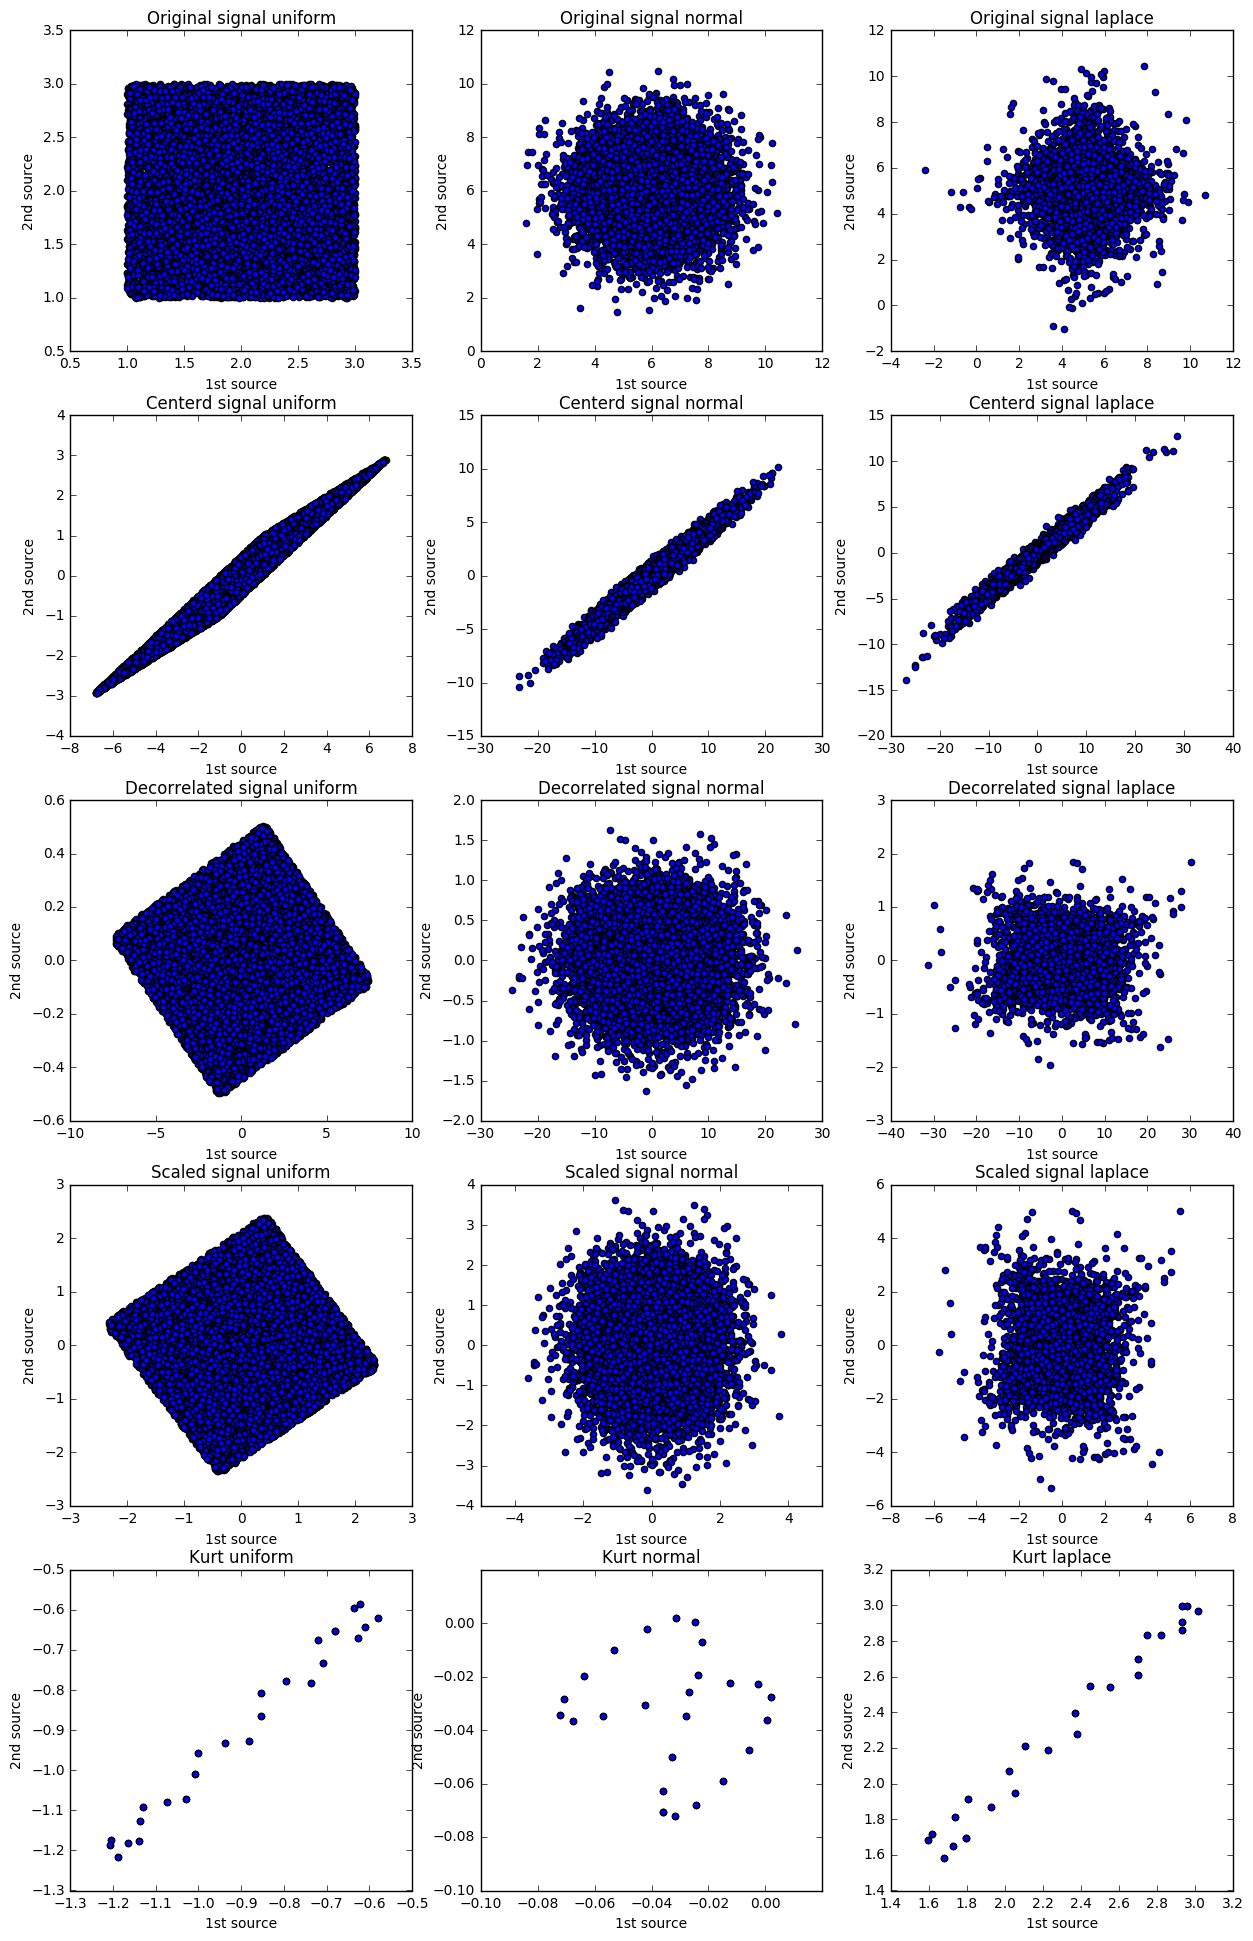

In [30]:
plt.figure(figsize=(15,24))

plt.subplot(5,3,1)
plt.scatter(suni[0],suni[1])
plt.title('Original signal uniform') 
plt.xlabel('1st source')
plt.ylabel('2nd source')

plt.subplot(5,3,2)
plt.scatter(snom[0],snom[1])
plt.title('Original signal normal') 
plt.xlabel('1st source')
plt.ylabel('2nd source')

plt.subplot(5,3,3)
plt.scatter(slap[0],slap[1])
plt.title('Original signal laplace') 
plt.xlabel('1st source')
plt.ylabel('2nd source')

plt.subplot(5,3,4)
plt.scatter(xunic[0],xunic[1])
plt.title('Centerd signal uniform') 
plt.xlabel('1st source')
plt.ylabel('2nd source')

plt.subplot(5,3,5)
plt.scatter(xnomc[0],xnomc[1])
plt.title('Centerd signal normal') 
plt.xlabel('1st source')
plt.ylabel('2nd source')

plt.subplot(5,3,6)
plt.scatter(xlapc[0],xlapc[1])
plt.title('Centerd signal laplace') 
plt.xlabel('1st source')
plt.ylabel('2nd source')

plt.subplot(5,3,7)
plt.scatter(unideco[0],unideco[1])
plt.title('Decorrelated signal uniform')
plt.xlabel('1st source')
plt.ylabel('2nd source')

plt.subplot(5,3,8)
plt.scatter(nomdeco[0],nomdeco[1])
plt.title('Decorrelated signal normal') 
plt.xlabel('1st source')
plt.ylabel('2nd source')

plt.subplot(5,3,9)
plt.scatter(lapdeco[0],lapdeco[1])
plt.title('Decorrelated signal laplace') 
plt.xlabel('1st source')
plt.ylabel('2nd source')

plt.subplot(5,3,10)
plt.scatter(vuni[0],vuni[1])
plt.title('Scaled signal uniform')
plt.xlabel('1st source')
plt.ylabel('2nd source')

plt.subplot(5,3,11)
plt.scatter(vnom[0],vnom[1])
plt.title('Scaled signal normal') 
plt.xlabel('1st source')
plt.ylabel('2nd source')

plt.subplot(5,3,12)
plt.scatter(vlap[0],vlap[1])
plt.title('Scaled signal laplace') 
plt.xlabel('1st source')
plt.ylabel('2nd source')

plt.subplot(5,3,13)
plt.scatter(kurtu[:,0],kurtu[:,1])
plt.title('Kurt uniform')
plt.xlabel('1st source')
plt.ylabel('2nd source')

plt.subplot(5,3,14)
plt.scatter(kurtn[:,0],kurtn[:,1])
plt.title('Kurt normal') 
plt.xlabel('1st source')
plt.ylabel('2nd source')

plt.subplot(5,3,15)
plt.scatter(kurtl[:,0],kurtl[:,1])
plt.title('Kurt laplace') 
plt.xlabel('1st source')
plt.ylabel('2nd source')

Max kurt for 1st dim of uniform =  -0.580652530548
when theta =  4.9008845396
Min kurt for 1st dim of uniform =  -1.20781182352
when theta =  1.00530964915
Max kurt for 1st dim of normal =  0.0019696390944
when theta =  2.38761041673
Min kurt for 1st dim of normal =  -0.0722653620622
when theta =  4.64955712731
Max kurt for 1st dim of laplace =  3.0192505451
when theta =  2.51327412287
Min kurt for 1st dim of laplace =  1.59453711832
when theta =  1.75929188601


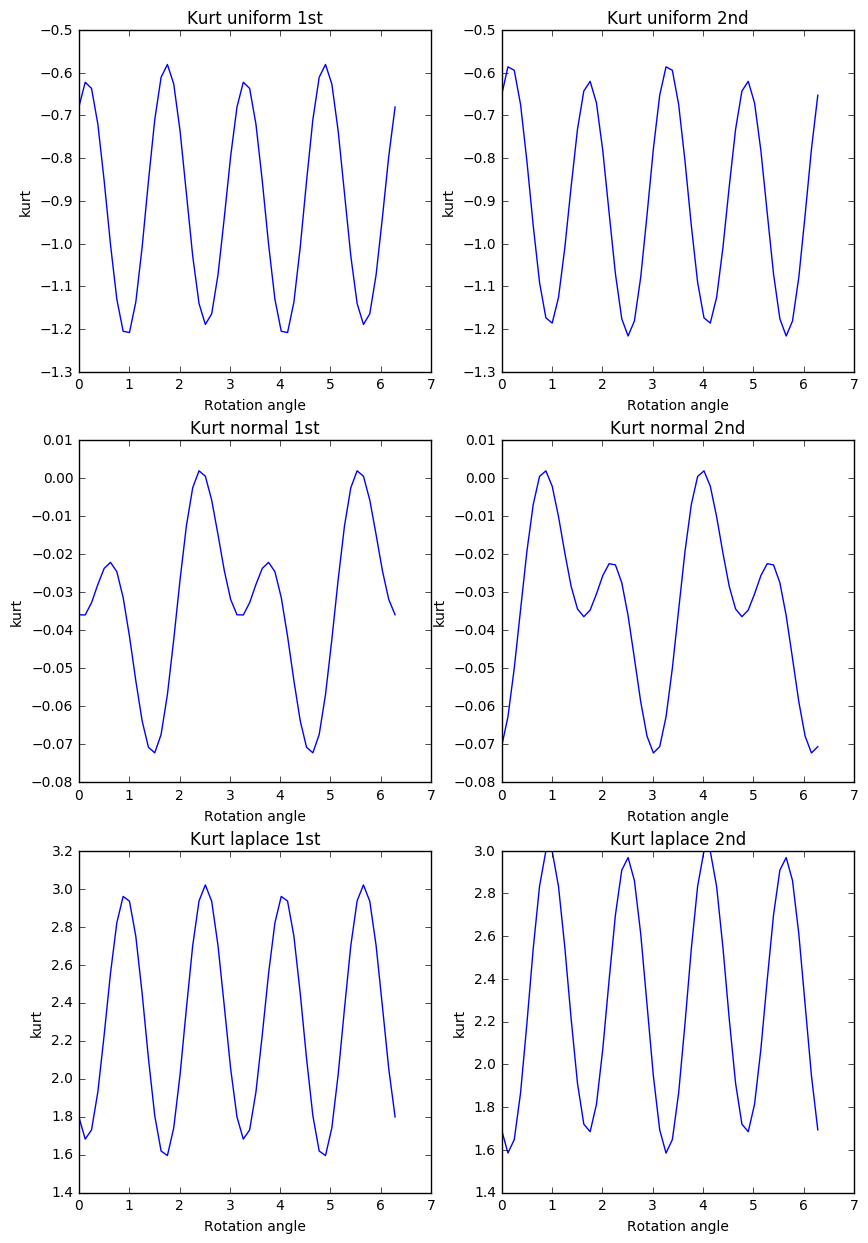

In [35]:
print("Max kurt for 1st dim of uniform = ", np.max(kurtu[:,0]))
print("when theta = ", tharr[np.argmax(kurtu[:,0])])
print("Min kurt for 1st dim of uniform = ", np.min(kurtu[:,0]))
print("when theta = ", tharr[np.argmin(kurtu[:,0])])

print("Max kurt for 1st dim of normal = ", np.max(kurtn[:,0]))
print("when theta = ", tharr[np.argmax(kurtn[:,0])])
print("Min kurt for 1st dim of normal = ", np.min(kurtn[:,0]))
print("when theta = ", tharr[np.argmin(kurtn[:,0])])

print("Max kurt for 1st dim of laplace = ", np.max(kurtl[:,0]))
print("when theta = ", tharr[np.argmax(kurtl[:,0])])
print("Min kurt for 1st dim of laplace = ", np.min(kurtl[:,0]))
print("when theta = ", tharr[np.argmin(kurtl[:,0])])

plt.figure(figsize=(10,15))

plt.subplot(3,2,1)
plt.plot(tharr,kurtu[:,0])
plt.title('Kurt uniform 1st') 
plt.ylabel('kurt')
plt.xlabel('Rotation angle')

plt.subplot(3,2,2)
plt.plot(tharr,kurtu[:,1])
plt.title('Kurt uniform 2nd') 
plt.ylabel('kurt')
plt.xlabel('Rotation angle')

plt.subplot(3,2,3)
plt.plot(tharr,kurtn[:,0])
plt.title('Kurt normal 1st') 
plt.ylabel('kurt')
plt.xlabel('Rotation angle')

plt.subplot(3,2,4)
plt.plot(tharr,kurtn[:,1])
plt.title('Kurt normal 2nd') 
plt.ylabel('kurt')
plt.xlabel('Rotation angle')

plt.subplot(3,2,5)
plt.plot(tharr,kurtl[:,0])
plt.title('Kurt laplace 1st') 
plt.ylabel('kurt')
plt.xlabel('Rotation angle')

plt.subplot(3,2,6)
plt.plot(tharr,kurtl[:,1])
plt.title('Kurt laplace 2nd') 
plt.ylabel('kurt')
plt.xlabel('Rotation angle')

In [83]:

histumax = rot(suni,tharr[np.argmax(kurtu[:,0])])
histumin = rot(suni,tharr[np.argmin(kurtu[:,0])])

histnmax = rot(snom,tharr[np.argmax(kurtn[:,0])])
histnmin = rot(snom,tharr[np.argmin(kurtn[:,0])])

histlmax = rot(slap,tharr[np.argmax(kurtl[:,0])])
histlmin = rot(slap,tharr[np.argmin(kurtl[:,0])])



(2, 10000)

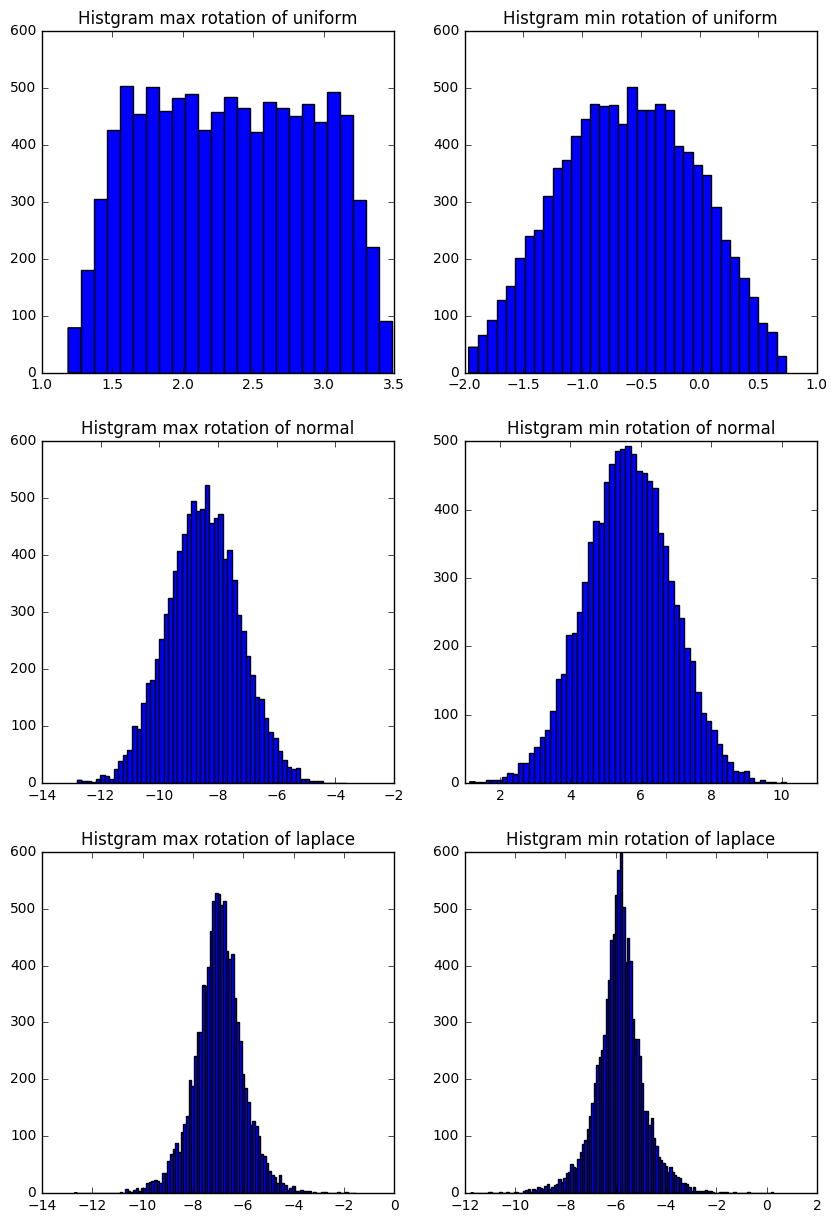

In [85]:
plt.figure(figsize=(10,15))
plt.subplot(3,2,1)
plt.hist(histumax[0], bins='auto')
plt.title('Histgram max rotation of uniform')

plt.subplot(3,2,2)
plt.hist(histumin[0], bins='auto')
plt.title('Histgram min rotation of uniform')

plt.subplot(3,2,3)
plt.hist(histnmax[0], bins='auto')
plt.title('Histgram max rotation of normal')

plt.subplot(3,2,4)
plt.hist(histnmin[0], bins='auto')
plt.title('Histgram min rotation of normal')

plt.subplot(3,2,5)
plt.hist(histlmax[0], bins='auto')
plt.title('Histgram max rotation of laplace')

plt.subplot(3,2,6)
plt.hist(histlmin[0], bins='auto')
plt.title('Histgram min rotation of laplace')
